In [36]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [37]:
historical = pd.read_csv('calls-2024-01-19.csv').set_index("Date").sort_index()

last_date  = pd.to_datetime(historical.index[-1])
next_date = last_date + pd.Timedelta(days=1)
next_date = next_date.strftime('%Y-%m-%d')

spx = yf.download("^SPX", start=historical.index[0], end=next_date)['Close']
irx = yf.download("^IRX", start=historical.index[0], end=next_date)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [38]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

def fBS_call_price(S, K, T, t, r, sigma, H):
    """
    Calculate the price of a European call option under the fractional Black-Scholes model.

    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        t (float): Current time (in years).
        r (float): Risk-free interest rate.
        sigma (float): Volatility.
        H (float): Hurst parameter (0 < H < 1).

    Returns:
        float: Price of the call option.
    """
    # Time difference
    tau = T - t
    if tau <= 0:
        return max(S - K, 0)  # Handle expiry case

    # Adjusted volatility term
    sigma_adj = sigma * np.sqrt((T**(2 * H) - t**(2 * H)) / (2 * H))

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma_adj**2) * tau) / (sigma_adj * np.sqrt(tau))
    d2 = d1 - sigma_adj * np.sqrt(tau)

    # Calculate the call price
    call_price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    return call_price

def calibrate_fBS_full(params):
    """
    Computes the squared error between model prices and observed market prices.

    Parameters:
        params: List containing [sigma, H].

    Returns:
        float: Sum of squared errors.
    """    
    H, sigma = params
    temp_df = historical.copy()
    total = []

    for rows in temp_df.iterrows():
        date_index = rows[0]
        s = float(spx.loc[date_index].item())
        r = float(irx.loc[date_index].item())*0.01
        t = (pd.to_datetime(maturity_date) - pd.to_datetime(date_index)).days / 365

        for i, v in rows[1].to_dict().items():
            if not np.isnan(v):
                c = fBS_call_price(s, float(i), t, 0, r, sigma, H)
                total.append((c - v)**2)
    mse = sum(total)/len(total)
    return mse

result = minimize(calibrate_fBS_full,
    [0.9, 0.5],
    method='L-BFGS-B',
    bounds=[(0.001, 0.999)]
    )

maturity_date = '2024-01-19'

H, sigma = result.x
print(H, sigma)

0.25089479581588253 0.114291368910792


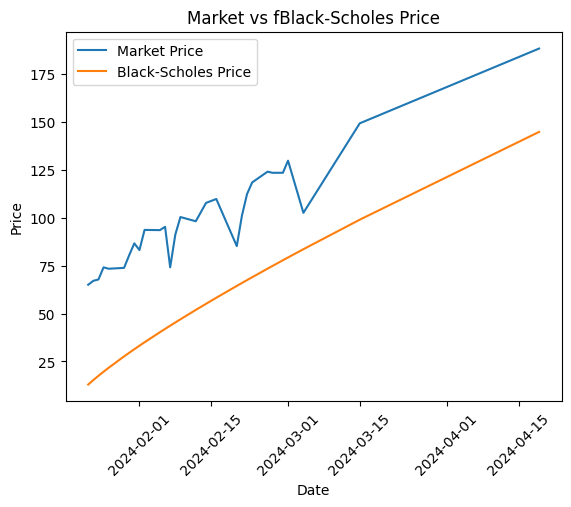

In [39]:
future_options = pd.read_csv('weekly_contracts_100.csv')

K = 4775.0

temp_df = future_options[future_options.Strike == K]\
    [['Maturity', 'Close']]
temp_df['Maturity'] = pd.to_datetime(temp_df['Maturity'])

temp_df = temp_df[temp_df['Maturity'] < '2024-05-01']

temp_df.sort_values(by='Maturity', inplace=True)

s0 = spx.iloc[-1].item()
r = irx.iloc[-1].item()*0.01

T = lambda x: (x - pd.to_datetime(maturity_date)).days / 365

temp_df['fBS']  = temp_df["Maturity"].apply(
        lambda x: fBS_call_price(s0, K, T(x), 0, r, sigma, H)
    )

plt.plot(temp_df['Maturity'], temp_df['Close'], label='Market Price')
plt.plot(temp_df['Maturity'], temp_df['fBS'], label='Black-Scholes Price')
plt.tick_params(axis='x', rotation=45)

plt.legend(['Market Price', 'Black-Scholes Price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Market vs fBlack-Scholes Price")

plt.show()

In [40]:
print("Least Squares Error: ", ((temp_df['fBS'] - temp_df['Close'])**2).mean())

Least Squares Error:  2303.225623997813


In [41]:
spx_on_maturity = yf.download("^SPX", start='2024-01-01', end='2024-12-31')['Close']
spx_on_maturity = spx_on_maturity[spx_on_maturity.index.isin(temp_df['Maturity'])]


temp_df['SPX'] = temp_df['Maturity'].map(spx_on_maturity.to_dict()['^SPX'])

temp_df["Payoff"] = temp_df.apply(lambda x: x['SPX'] - K, axis=1)
temp_df["Payoff Ratio"] = temp_df["Payoff"] / temp_df["Close"]

[*********************100%***********************]  1 of 1 completed

In [42]:
np.corrcoef(
    np.abs(temp_df['Close']-temp_df['fBS']), 
    temp_df['Payoff Ratio']
)

array([[ 1.        , -0.51559818],
       [-0.51559818,  1.        ]])